# Loan Recommendation System 
# Approach - 2 
## POC - Proof Of Concept

<img src="ClusterSchema.png" />

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, expr, rank, count #countDistinct
from pyspark.sql import functions as F
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.linalg import Vectors  ##DenseMatrix
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import operator
import time

In [3]:
spark = SparkSession.builder.appName('loan_recommendation_with_clusters').config("spark.driver.memory", "12g").getOrCreate()

In [4]:
# loans_df = spark.read.csv("RecommendData/df_temp_cluster_rating_condition_data.csv", inferSchema=True, header=True)
loans_df = spark.read.csv("Loan_Dataset/df_demographic_data_approrach-2_V-3.csv", inferSchema=True, header=True)

loans_df.printSchema()

root
 |-- Id: string (nullable = true)
 |-- AccountID: string (nullable = true)
 |-- Number_Of_Loans_Granted__c: integer (nullable = true)
 |-- Num_Of_Loans_Paid__c: integer (nullable = true)
 |-- Purpose_of_Loan__c: string (nullable = true)
 |-- Total_Repayments__c: integer (nullable = true)
 |-- Amount: integer (nullable = true)
 |-- Term_in_Weeks__c: double (nullable = true)
 |-- Payment_Frequency__c: string (nullable = true)
 |-- StageName: string (nullable = true)
 |-- Applicant Age: integer (nullable = true)
 |-- summary_income: double (nullable = true)
 |-- summary_income_cv: double (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- userId: integer (nullable = true)
 |-- loanId: integer (nullable = true)
 |-- count: integer (nullable = true)
 |-- Cluster_result: integer (nullable = true)
 |-- Cluster_Group: integer (nullable = true)



In [8]:
loans_df.select(["Amount","Total_Repayments__c","Payment_Frequency__c","count","Cluster_Group"]).describe().show(10)

+-------+-----------------+-------------------+--------------------+------------------+------------------+
|summary|           Amount|Total_Repayments__c|Payment_Frequency__c|             count|     Cluster_Group|
+-------+-----------------+-------------------+--------------------+------------------+------------------+
|  count|           477055|             477055|              477055|            477055|            477055|
|   mean| 861.086143107189|  7.077596922786681|                NULL|1.6787079057970256| 4.807672071354456|
| stddev|809.0345512261636|  4.138158271816722|                NULL|0.9003499221145996|1.9419656955246842|
|    min|              100|                  1|         Fortnightly|                 0|                 1|
|    max|             5000|                 45|              Weekly|                 8|                11|
+-------+-----------------+-------------------+--------------------+------------------+------------------+



* Id: Likely a unique identifier for each data point.
* AccountID: Unique identifier for an account (possibly borrower).
* Loan-related features: 
    1. Number_Of_Loans_Granted__c: Number of loans granted to the account.
    2. Num_Of_Loans_Paid__c: Number of loans paid by the account.
    3. Purpose_of_Loan__c: Category of the loan purpose (e.g., mortgage, education).
    4. Total_Repayments__c: Total amount repaid by the account.
    5. Amount: Loan amount requested.
    6. Term_in_Weeks__c: Loan term in weeks.
    7. Payment_Frequency__c: Frequency of loan repayment (e.g., weekly, monthly).
* Borrower-related features:
    1. StageName: Current stage of the loan application (e.g., application, approved, rejected).    
    2. Applicant Age: Age of the loan applicant    
    3. summary_income: Summary of applicant's incom    
    4. summary_income_cv: Coefficient of variation of applicant's income
    5. Location-related features:
    6. city: City of the applicant.
    7. state: State of the applicant.
    8. Country: Country of the applicant
* Additional features:
    1. userId: Unique identifier for a user Account Id in Numeric).     
    2. loanId: Unique identifier for a lo (Id or loanId in Numeric)
    3. counFeature related to the Ratings of the Loans.
    4. LoanIdFormat: Format of the loan(Created LoanId using Clusters).

In [9]:
loans_df.select(["Cluster_Group","Cluster_result","Amount","Total_Repayments__c","Payment_Frequency__c","count"]).show(10)

+-------------+--------------+------+-------------------+--------------------+-----+
|Cluster_Group|Cluster_result|Amount|Total_Repayments__c|Payment_Frequency__c|count|
+-------------+--------------+------+-------------------+--------------------+-----+
|            1|             1|   100|                  6|              Weekly|    1|
|            1|             1|   100|                  3|         Fortnightly|    1|
|            1|             1|   100|                  3|         Fortnightly|    1|
|            1|             1|   150|                  3|         Fortnightly|    1|
|            1|             1|   100|                  3|         Fortnightly|    1|
|            1|             1|   150|                 10|              Weekly|    1|
|            1|             1|   100|                  6|              Weekly|    1|
|            1|             1|   100|                  3|         Fortnightly|    1|
|            1|             2|   200|                  3|        

### Aggregating the loans per user (getting all loans for each user user)

In [10]:
user_loans = loans_df.groupby("userId").agg(F.collect_set("Cluster_result").alias("loans"))

In [11]:
Actual_loans_taken = user_loans.toPandas().to_dict('records')

### EDA - Exploratory Data Analysis 

<img src="https://editor.analyticsvidhya.com/uploads/24537Zoom-EDA.png" height=500 width="500" />

In [13]:
loans_df.select(["Cluster_Group","userId","Cluster_result","count","Amount","Number_Of_Loans_Granted__c","Num_Of_Loans_Paid__c"]).describe().show()

+-------+------------------+------------------+-----------------+------------------+-----------------+--------------------------+--------------------+
|summary|     Cluster_Group|            userId|   Cluster_result|             count|           Amount|Number_Of_Loans_Granted__c|Num_Of_Loans_Paid__c|
+-------+------------------+------------------+-----------------+------------------+-----------------+--------------------------+--------------------+
|  count|            477055|            477055|           477055|            477055|           477055|                    477055|              477055|
|   mean| 4.807672071354456|24327.947192671705|11.56178637683286|1.6787079057970256| 861.086143107189|        11.977491064971543|  11.937413925019127|
| stddev|1.9419656955246842|15298.881686613546| 8.30279183207504|0.9003499221145996|809.0345512261636|         8.190257284475846|    8.31394345430114|
|    min|                 1|                 1|                1|                 0|          

#### Plotting the Frequnecy of Count(Ratings)

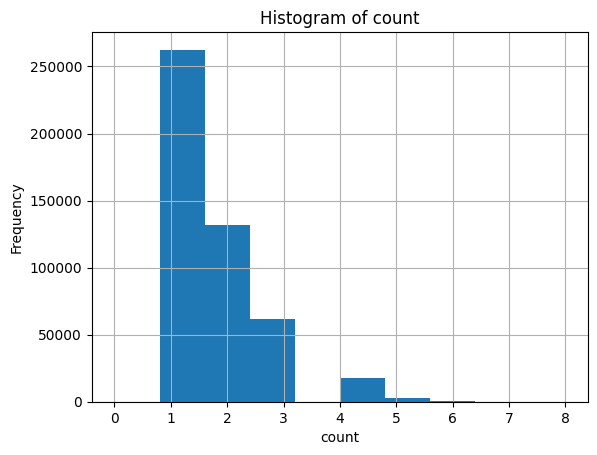

In [14]:
hist_data  = loans_df.toPandas()

hist_data['count'].hist()
plt.xlabel("count")
plt.ylabel("Frequency")
plt.title(f"Histogram of count")
plt.show()

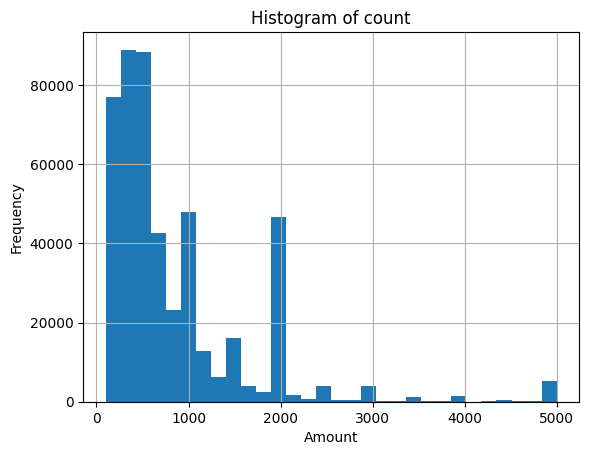

In [15]:
hist_data['Amount'].hist(bins=30)
plt.xlabel("Amount")
plt.ylabel("Frequency")
plt.title(f"Histogram of count")
plt.show()

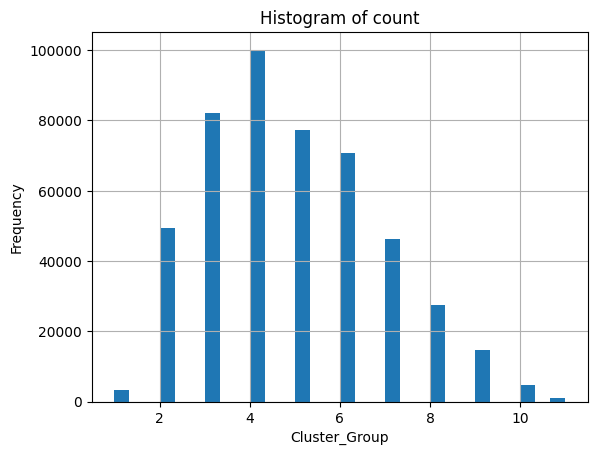

In [16]:
hist_data['Cluster_Group'].hist(bins=30)
plt.xlabel("Cluster_Group")
plt.ylabel("Frequency")
plt.title(f"Histogram of count")
plt.show()

#### Counting the No. of user & No. of Loans & No. of Explicitely Created Loan Id (Clustered Loan Id's)

In [17]:
# Count the number of unique items
num_unique_loan_id_format = loans_df.select('Cluster_result').distinct().count()
print(f"Number of unique loanId_format: {num_unique_loan_id_format}")

# Count the number of unique users
num_unique_id = loans_df.select('Id').distinct().count()
print(f"Number of unique Loan Id: {num_unique_id}")

Number of unique loanId_format: 38
Number of unique Loan Id: 404122


In [18]:
# Count the number of unique items
tmp = loans_df.select('userId').distinct().count()
print(f"Number of unique users: {tmp}")

Number of unique users: 58698


In [19]:
# creating a temporary view of 
# Dataframe and storing it into df2
loans_df.createOrReplaceTempView("df2")

In [20]:
# User Groups and their respective counts counts

In [22]:
 
# using the SQL query to count all
# distinct records and display the
# count on the screen
spark.sql("SELECT Cluster_Group, COUNT(*) AS count FROM df2 GROUP BY Cluster_Group").show()

+-------------+------+
|Cluster_Group| count|
+-------------+------+
|            1|  3287|
|            3| 82232|
|            2| 49284|
|            5| 77201|
|            4|100164|
|            6| 70822|
|            9| 14643|
|            8| 27480|
|            7| 46237|
|           10|  4661|
|           11|  1044|
+-------------+------+



In [23]:
spark.sql("SELECT count, COUNT(*) AS count FROM df2 GROUP BY count").show()

+-----+------+
|count| count|
+-----+------+
|    1|262492|
|    6|   523|
|    3| 61542|
|    5|  2910|
|    4| 17904|
|    2|131481|
|    7|   124|
|    0|     6|
|    8|    73|
+-----+------+



In [24]:
spark.sql("SELECT Cluster_result, COUNT(*) AS count FROM df2 GROUP BY Cluster_result").show()

+--------------+-----+
|Cluster_result|count|
+--------------+-----+
|            31|  257|
|            34|  188|
|            28|  259|
|            26| 2741|
|            27| 3648|
|            12|14552|
|            22| 3254|
|             1|  202|
|            13| 4940|
|             6|32437|
|            16|45885|
|             3|18419|
|            20| 4472|
|             5|13457|
|            19| 4155|
|            15| 8363|
|            37|  429|
|             9| 3537|
|            17| 3605|
|            35| 1461|
+--------------+-----+
only showing top 20 rows



#### Values of count(Rating) Column.

In [25]:
print('Distinct values of count:')
loans_df.select('count').distinct().orderBy("count").show()

Distinct values of count:
+-----+
|count|
+-----+
|    0|
|    1|
|    2|
|    3|
|    4|
|    5|
|    6|
|    7|
|    8|
+-----+



### Converting the dataset into train validation split.

In [27]:
# we have to use 3 columns or features to put into the ALs Model.
loans_df.select(["Cluster_result","count","Cluster_Group"]).show(10)

+--------------+-----+-------------+
|Cluster_result|count|Cluster_Group|
+--------------+-----+-------------+
|             1|    1|            1|
|             1|    1|            1|
|             1|    1|            1|
|             1|    1|            1|
|             1|    1|            1|
|             1|    1|            1|
|             1|    1|            1|
|             1|    1|            1|
|             2|    1|            1|
|             2|    1|            1|
+--------------+-----+-------------+
only showing top 10 rows



In [28]:
train, validation = loans_df.randomSplit([0.8, 0.2])
train.cache()
validation.cache()

DataFrame[Id: string, AccountID: string, Number_Of_Loans_Granted__c: int, Num_Of_Loans_Paid__c: int, Purpose_of_Loan__c: string, Total_Repayments__c: int, Amount: int, Term_in_Weeks__c: double, Payment_Frequency__c: string, StageName: string, Applicant Age: int, summary_income: double, summary_income_cv: double, city: string, state: string, Country: string, userId: int, loanId: int, count: int, Cluster_result: int, Cluster_Group: int]

In [29]:
validation.select(["Cluster_Group","userId","loanId","Cluster_result","count","Amount","Total_Repayments__c"]).show()

+-------------+------+------+--------------+-----+------+-------------------+
|Cluster_Group|userId|loanId|Cluster_result|count|Amount|Total_Repayments__c|
+-------------+------+------+--------------+-----+------+-------------------+
|            2| 23942|    26|            12|    3|   700|                  5|
|            3|   149|    29|             2|    1|   200|                 10|
|            3|   161|    50|             8|    1|   500|                  3|
|            3| 24477|   108|             7|    5|   450|                  2|
|            3| 23462|   126|             8|    2|   500|                 10|
|            3| 23462|   126|             8|    2|   500|                 10|
|            3|    31|   169|             3|    2|   250|                  1|
|            3|    41|   178|            14|    2|   800|                  4|
|            3| 23398|   188|             2|    2|   200|                  5|
|            3| 24391|   201|             2|    1|   200|       

In [30]:
loans_df.printSchema()

root
 |-- Id: string (nullable = true)
 |-- AccountID: string (nullable = true)
 |-- Number_Of_Loans_Granted__c: integer (nullable = true)
 |-- Num_Of_Loans_Paid__c: integer (nullable = true)
 |-- Purpose_of_Loan__c: string (nullable = true)
 |-- Total_Repayments__c: integer (nullable = true)
 |-- Amount: integer (nullable = true)
 |-- Term_in_Weeks__c: double (nullable = true)
 |-- Payment_Frequency__c: string (nullable = true)
 |-- StageName: string (nullable = true)
 |-- Applicant Age: integer (nullable = true)
 |-- summary_income: double (nullable = true)
 |-- summary_income_cv: double (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- userId: integer (nullable = true)
 |-- loanId: integer (nullable = true)
 |-- count: integer (nullable = true)
 |-- Cluster_result: integer (nullable = true)
 |-- Cluster_Group: integer (nullable = true)



In [32]:
def train_ALS(train_data, validation_data, num_iters, reg_param, ranks):
    """
    Grid Search Function to select the best model based on RMSE of hold-out data
    """
    # initial
    min_error = float('inf')
    best_rank = -1
    best_regularization = 0
    best_model = None
    for rank in ranks:
        for reg in reg_param:
            # Train the model using the training data
            als_model = ALS(maxIter=num_iters,regParam=reg, rank=rank,
                                        userCol='Cluster_Group', itemCol='Cluster_result', ratingCol='count', seed=99,
                           coldStartStrategy="drop",nonnegative=True)
            model = als_model.fit(train_data)

            # Generate predictions on the test data
            predictions = model.transform(validation_data)
            predictions = predictions.withColumn("prediction", expr("CASE WHEN prediction < 0 THEN 0 WHEN prediction > 9 THEN 9 ELSE prediction END"))

            evaluator = RegressionEvaluator(metricName='rmse', labelCol='count', predictionCol='prediction')
            error = evaluator.evaluate(predictions)

            print('{} latent factors and regularization = {}: validation RMSE is {}'.format(rank, reg, error))
            if error < min_error:
                min_error = error
                best_rank = rank
                best_regularization = reg
                best_model = model
    print('\nThe best model has {} latent factors and regularization = {}'.format(best_rank, best_regularization))
    return best_model

In [33]:
# hyper-param config
num_iterations = 10
ranks = [8, 10, 20, 40, 60]
reg_params = [0.001, 0.01, 0.05, 0.1, 0.2]

# grid search and select best model
start_time = time.time()
final_model = train_ALS(train, validation, num_iterations, reg_params, ranks)

print ('Total Runtime: {:.2f} seconds'.format(time.time() - start_time))

8 latent factors and regularization = 0.001: validation RMSE is 0.8796292214136551
8 latent factors and regularization = 0.01: validation RMSE is 0.8797088068006153
8 latent factors and regularization = 0.05: validation RMSE is 0.8812924882101534
8 latent factors and regularization = 0.1: validation RMSE is 0.885679436532401
8 latent factors and regularization = 0.2: validation RMSE is 0.903659465361714
10 latent factors and regularization = 0.001: validation RMSE is 0.8796316837170337
10 latent factors and regularization = 0.01: validation RMSE is 0.8796573550542411
10 latent factors and regularization = 0.05: validation RMSE is 0.8812415664063938
10 latent factors and regularization = 0.1: validation RMSE is 0.8855711035555278
10 latent factors and regularization = 0.2: validation RMSE is 0.9036142667723303
20 latent factors and regularization = 0.001: validation RMSE is 0.8796479459777231
20 latent factors and regularization = 0.01: validation RMSE is 0.8796438664853292
20 latent fa

## Predicting the results from validation data

In [37]:
predictions = final_model.transform(validation)
# predictions = predictions.withColumn("prediction", expr("CASE WHEN prediction < 0 THEN 0 WHEN prediction > 9 THEN 9 ELSE prediction END"))

In [39]:
predictions.filter(predictions.userId == 10).select("usergroupCreate", "Cluster_result", "prediction").show(20)

+---------------+--------------+----------+
|usergroupCreate|Cluster_result|prediction|
+---------------+--------------+----------+
|              4|             2| 1.7807857|
|              4|             2| 1.7807857|
|              4|             3| 1.9077768|
|              4|             2| 1.7807857|
|              4|             2| 1.7807857|
|              4|             6| 1.8719528|
|              4|             8| 1.8735499|
|              4|             8| 1.8735499|
|              4|            12| 1.8589125|
+---------------+--------------+----------+



## Error Evaluation with RMSE

<img src="https://docs.oracle.com/en/cloud/saas/planning-budgeting-cloud/pfusu/img/insights_rmse_formula.jpg" height="300" width="300" />

In [40]:
# Evaluate the model using Root Mean Squared Error (RMSE)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="count", predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) = " + str(rmse))

Root Mean Squared Error (RMSE) = 0.880596604310158


## Recommendation of N users

In [41]:
userRecommends = final_model.recommendForAllUsers(5)
loanRecommends = final_model.recommendForAllItems(5)

In [42]:
userRecommends.printSchema()

root
 |-- usergroupCreate: integer (nullable = false)
 |-- recommendations: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- Cluster_result: integer (nullable = true)
 |    |    |-- rating: float (nullable = true)



In [43]:
validation.printSchema()

root
 |-- Id: string (nullable = true)
 |-- AccountID: string (nullable = true)
 |-- Number_Of_Loans_Granted__c: integer (nullable = true)
 |-- Num_Of_Loans_Paid__c: integer (nullable = true)
 |-- Purpose_of_Loan__c: string (nullable = true)
 |-- Total_Repayments__c: integer (nullable = true)
 |-- Amount: integer (nullable = true)
 |-- Term_in_Weeks__c: double (nullable = true)
 |-- Payment_Frequency__c: string (nullable = true)
 |-- StageName: string (nullable = true)
 |-- Applicant Age: integer (nullable = true)
 |-- summary_income: double (nullable = true)
 |-- summary_income_cv: double (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- userId: integer (nullable = true)
 |-- loanId: integer (nullable = true)
 |-- count: integer (nullable = true)
 |-- Cluster_result: integer (nullable = true)
 |-- usergroupCreate: integer (nullable = true)



In [44]:
validation.count()

95944

## ALS Model Evaluation

In [58]:
# Assuming you have a DataFrame 'validation_data' containing the ground truth interactions
# and a DataFrame 'recommendations' containing the top-N recommendations generated by the ALS model

# Join recommendations with ground truth data to identify true positives
true_positives = predictions.join(validation, ['usergroupCreate', 'Cluster_result'], 'inner')

In [59]:
# Calculate the number of true positives per user
tp_per_user = true_positives.groupBy('usergroupCreate').agg(expr('count(Cluster_result) as true_positives'))

In [60]:
 # Calculate the total number of relevant items per user in the ground truth data
relevant_per_user = validation.groupBy('usergroupCreate').agg(expr('count(Cluster_result) as relevant'))

In [62]:
# Calculate Precision per user
precision_per_user = tp_per_user.join(relevant_per_user, 'usergroupCreate', 'inner') \
    .selectExpr('usergroupCreate', 'true_positives / relevant as precision')

In [63]:
# Calculate Recall per user
recall_per_user = tp_per_user.join(relevant_per_user, 'usergroupCreate', 'inner') \
    .selectExpr('usergroupCreate', 'true_positives / relevant as recall')

In [64]:
# Calculate F1-score per user
f1_score_per_user = precision_per_user.join(recall_per_user, 'usergroupCreate', 'inner') \
    .selectExpr('usergroupCreate', '(2 * precision * recall) / (precision + recall) as f1_score')

In [65]:
# Calculate overall Precision, Recall, and F1-score
overall_precision = precision_per_user.agg({'precision': 'avg'}).collect()[0][0]
overall_recall = recall_per_user.agg({'recall': 'avg'}).collect()[0][0]
overall_f1_score = f1_score_per_user.agg({'f1_score': 'avg'}).collect()[0][0]


In [66]:

# Print the results
print("Overall Precision:", overall_precision)
print("Overall Recall:", overall_recall)
print("Overall F1-score:", overall_f1_score)


Overall Precision: 929.3433970924417
Overall Recall: 929.3433970924417
Overall F1-score: 929.3433970924418


In [67]:
evaluator = RegressionEvaluator(metricName="mae", labelCol="count", predictionCol="prediction")
mae = evaluator.evaluate(predictions)

In [68]:
"The Mean Absolute Error is :",mae

('The Mean Absolute Error is :', 0.7051579730927989)

## User Factors and Item Factors to calculate the cosine Similarity

In [69]:
userFactors = final_model.userFactors
itemFactors = final_model.itemFactors

In [70]:
print(userFactors.count())
print("Priting the Schema of userFactors",userFactors.printSchema())

8
root
 |-- id: integer (nullable = false)
 |-- features: array (nullable = true)
 |    |-- element: float (containsNull = false)

Priting the Schema of userFactors None


In [72]:

userFactors.filter(userFactors.id == 4 ).collect()

[Row(id=4, features=[0.0, 0.11932894587516785, 0.0, 0.0, 0.0, 0.0008733168360777199, 0.11637958884239197, 0.26093804836273193, 0.29018399119377136, 0.06533939391374588])]

In [74]:
userFactors.select("id","features").show(10,truncate=False)

+---+------------------------------------------------------------------------------------------------------+
|id |features                                                                                              |
+---+------------------------------------------------------------------------------------------------------+
|1  |[0.10207652, 0.0, 0.0, 0.0, 0.028071277, 0.217461, 0.0, 0.20388243, 0.27029592, 3.6434052E-4]         |
|2  |[0.1090944, 0.05858941, 0.0, 0.0, 0.05580347, 0.0, 0.0, 0.027221724, 0.32275096, 0.20567515]          |
|3  |[0.0, 0.121066555, 0.0, 0.0, 0.18417068, 0.04563323, 0.1560713, 0.0, 0.34213224, 0.0]                 |
|4  |[0.0, 0.119328946, 0.0, 0.0, 0.0, 8.7331684E-4, 0.11637959, 0.26093805, 0.290184, 0.065339394]        |
|5  |[0.058896516, 0.070902, 0.0, 0.0, 0.1048939, 0.20820643, 0.20759, 0.056931816, 0.03224951, 0.37312073]|
|6  |[0.055335354, 0.26035395, 0.0, 0.0, 0.7056479, 0.04746375, 0.0, 0.35699084, 0.0, 0.07413496]          |
|7  |[0.72662395, 0

In [73]:
itemFactors.select("id","features").show(10,truncate=False)

+---+-----------------------------------------------------------------------------------------------------+
|id |features                                                                                             |
+---+-----------------------------------------------------------------------------------------------------+
|10 |[1.0506967, 1.0377316, 0.0, 0.0, 0.5584275, 1.1679243, 1.0880078, 2.4268227, 3.3939633, 1.6737078]   |
|20 |[1.2366269, 0.6668619, 0.0, 0.0, 0.5444139, 0.8700933, 1.3070961, 2.3319182, 3.2417717, 1.8243557]   |
|30 |[1.268503, 0.877252, 0.0, 0.0, 0.6327881, 1.1561329, 0.69284576, 2.0294447, 3.0912063, 1.7711663]    |
|1  |[0.85906637, 1.4773526, 0.0, 0.0, 0.15889955, 1.4398404, 0.6260075, 0.93376863, 2.086219, 1.0415007] |
|11 |[1.2201872, 0.6199579, 0.0, 0.0, 0.27705252, 1.2503427, 1.5591296, 2.460763, 3.409021, 1.8289618]    |
|21 |[1.2936139, 0.9649519, 0.0, 0.0, 0.5394421, 1.468302, 1.1203814, 2.4098449, 3.229811, 1.6454054]     |
|31 |[0.81581944, 1.8065608,

## Calculate cosine similarity:

<img src="https://datascience103579984.files.wordpress.com/2020/01/13-12.png" height="600" width="600" />

In [75]:
def cosine_similarity(u1, u2):
    """Calculates cosine similarity between two user factors."""
    # Convert lists to DenseVectors before performing operations
    u1_vector = Vectors.dense(u1)
    u2_vector = Vectors.dense(u2)
    return u1_vector.dot(u2_vector) / (u1_vector.norm(p=2) * u2_vector.norm(p=2))

### user-User Cosine Similarity code

In [76]:
# Example usage
user1_id = 1
user2_id = 2
user1_factors = userFactors.filter(userFactors.id == user1_id ).collect()[0][1]
user2_factors = userFactors.filter(userFactors.id == user2_id ).collect()[0][1]
# user1_factors = userFactors.to_dense().rdd.filter(lambda x: x[0] == user1_id).collect()[0][1]
# user2_factors = userFactors.to_dense().rdd.filter(lambda x: x[0] == user2_id).collect()[0][1]
similarity = cosine_similarity(user1_factors, user2_factors)
print(f"Cosine similarity between users {user1_id} and {user2_id}: {similarity}")


Cosine similarity between users 1 and 2: 0.623353425685165


### User-Item Cosine Similarity code

In [77]:
# Example usage
user1_id = 1
item_id = 1
user_factors = userFactors.filter(userFactors.id == user1_id ).collect()[0][1]
item_factors = itemFactors.filter(itemFactors.id == item_id ).collect()[0][1]

user_item_similarity = cosine_similarity(user_factors, item_factors)
print(f"Cosine similarity between users {user1_id} and {item_id}: {user_item_similarity}")

Cosine similarity between users 1 and 1: 0.8143035069669178


###  Cosine Similarity of user 10 with all Loans

In [78]:
TopCosineLoanforuser10 = []
for item in range(itemFactors.count()):
    item_id = itemFactors.select("Id").sort("Id").take(itemFactors.count())[item][0]
    user1_id = 1
    user_factors = userFactors.filter(userFactors.id == user1_id ).collect()[0][1]
    item_factors = itemFactors.filter(itemFactors.id == item_id ).collect()[0][1]


    user_item_similarity = cosine_similarity(user_factors, item_factors)
    TopCosineLoanforuser10.append({"userID":user1_id,"LoanId":item_id,"CosineSimilarity":user_item_similarity})

In [79]:
sorted_Cosine_list = sorted(TopCosineLoanforuser10, key=operator.itemgetter('CosineSimilarity'),reverse=True)
sorted_Cosine_list

[{'userID': 1, 'LoanId': 19, 'CosineSimilarity': 0.8776531556618067},
 {'userID': 1, 'LoanId': 21, 'CosineSimilarity': 0.8758911055323454},
 {'userID': 1, 'LoanId': 27, 'CosineSimilarity': 0.8751143293753244},
 {'userID': 1, 'LoanId': 4, 'CosineSimilarity': 0.8690645747610348},
 {'userID': 1, 'LoanId': 22, 'CosineSimilarity': 0.8665435683775703},
 {'userID': 1, 'LoanId': 14, 'CosineSimilarity': 0.8662491779207898},
 {'userID': 1, 'LoanId': 16, 'CosineSimilarity': 0.8662477276301079},
 {'userID': 1, 'LoanId': 15, 'CosineSimilarity': 0.861866123093482},
 {'userID': 1, 'LoanId': 2, 'CosineSimilarity': 0.8602333329627471},
 {'userID': 1, 'LoanId': 6, 'CosineSimilarity': 0.8597760996643419},
 {'userID': 1, 'LoanId': 24, 'CosineSimilarity': 0.8565389389188246},
 {'userID': 1, 'LoanId': 30, 'CosineSimilarity': 0.8563701742208709},
 {'userID': 1, 'LoanId': 18, 'CosineSimilarity': 0.8562518067254814},
 {'userID': 1, 'LoanId': 10, 'CosineSimilarity': 0.8559761999510244},
 {'userID': 1, 'LoanId':

### Cosine Similarity of all users with all loans

In [80]:
# Collect all user factors into a dictionary
user_factors_dict = userFactors.select("id", "features").rdd.collectAsMap()

# Broadcast the user factors dictionary to all workers
broadcast_user_factors = spark.sparkContext.broadcast(user_factors_dict)

# Collect all item factors into a dictionary
item_factors_dict = itemFactors.select("id", "features").rdd.collectAsMap()

# Broadcast the item factors dictionary to all workers
broadcast_item_factors = spark.sparkContext.broadcast(item_factors_dict)

In [82]:
# Initially the code is like this !!
def cosine_similarity(u1, u2):
    """Calculates cosine similarity between two user group factors."""
    # Convert lists to DenseVectors before performing operations
    u1_vector = Vectors.dense(u1)
    u2_vector = Vectors.dense(u2)
    return u1_vector.dot(u2_vector) / (u1_vector.norm(p=2) * u2_vector.norm(p=2))

def cosine_similarity(vec1, vec2):
    dot_product = sum(v1 * v2 for v1, v2 in zip(vec1, vec2))
    magnitude1 = sum(v ** 2 for v in vec1) ** 0.5
    magnitude2 = sum(v ** 2 for v in vec2) ** 0.5
    return dot_product / (magnitude1 * magnitude2)

In [83]:


# Initialize list to store recommendations
CosineSilty_first10 = []
starttime = time.time()
Nusers = userFactors.select("id").count()

# Iterate over users
for userId in range(1, Nusers):
    user_factors = broadcast_user_factors.value.get(userId)
    if user_factors:
        TopCosineLoanforuser10 = []
        # Iterate over items
        for item_id, item_factors in broadcast_item_factors.value.items():
            user_item_similarity = cosine_similarity(user_factors, item_factors)
            TopCosineLoanforuser10.append({item_id: user_item_similarity})

        # Sort recommendations based on similarity
        Recomnd_loans = sorted(TopCosineLoanforuser10, key=lambda x: list(x.values())[0], reverse=True)
        CosineSilty_first10.append({"UserId": userId, "Recommendation": Recomnd_loans})

endtime = time.time()
runtime_hours = (endtime - starttime) / 3600
print(f"The time taken to run code for {Nusers} users is : {runtime_hours} hours")

The time taken to run code for 8 users is : 3.108706739213732e-05 hours


In [84]:
# Define a function to extract top-N recommendations
def extract_top_n_recommendations(recommendations_data, n=2500):
    top_n_recommendations = [{'userId': user_recommendation['UserId'],
                              'Recommendation': [list(rec.keys())[0] for rec in user_recommendation['Recommendation'][:n]]}
                             for user_recommendation in recommendations_data]
    return top_n_recommendations

# Extract top-N recommendations
starttime = time.time()
top_n_recommendations = extract_top_n_recommendations(CosineSilty_first10, n=5)
endtime = time.time()
runtime_hours = (endtime - starttime) / 3600


In [85]:
top_n_recommendations

[{'userId': 1, 'Recommendation': [19, 21, 27, 4, 22]},
 {'userId': 2, 'Recommendation': [38, 32, 36, 34, 35]},
 {'userId': 3, 'Recommendation': [28, 29, 36, 26, 22]},
 {'userId': 4, 'Recommendation': [10, 14, 26, 17, 24]},
 {'userId': 5, 'Recommendation': [34, 33, 9, 38, 7]},
 {'userId': 6, 'Recommendation': [26, 35, 9, 30, 10]},
 {'userId': 7, 'Recommendation': [37, 23, 18, 29, 27]}]

In [86]:
# Function to recommend top N loans not taken by the user
def recommend_loans_not_taken(user_id, recommendations, actual_loans_taken, top_n):
    taken_loans = set(actual_loans_taken.get(user_id, []))
    recommended_loans = []
    for rec in recommendations:
        loan_id = list(rec.keys())[0]
        if loan_id not in taken_loans:
            recommended_loans.append(loan_id)
            if len(recommended_loans) == top_n:
                break
    return recommended_loans

# Define a dictionary to store actual loans taken by each user
actual_loans_taken_dict = {record['userId']: record['loans'] for record in Actual_loans_taken}

# Create a list to store recommendations for each user
recommendations_for_users = []

# Iterate over each user
for rec_user in CosineSilty_first10:
    user_id = rec_user['UserId']
    recommendations = rec_user['Recommendation']
    # Recommend top N loans not taken by the user
    recommended_loans = recommend_loans_not_taken(user_id, recommendations, actual_loans_taken_dict, top_n=5)
    recommendations_for_users.append({'UserId': user_id, 'Recommendations': recommended_loans})



In [87]:
recommendations_for_users

[{'UserId': 1, 'Recommendations': [19, 27, 4, 22, 2]},
 {'UserId': 2, 'Recommendations': [38, 32, 36, 34, 35]},
 {'UserId': 3, 'Recommendations': [28, 29, 36, 26, 22]},
 {'UserId': 4, 'Recommendations': [10, 14, 26, 17, 24]},
 {'UserId': 5, 'Recommendations': [34, 33, 9, 38, 7]},
 {'UserId': 6, 'Recommendations': [26, 35, 9, 30, 10]},
 {'UserId': 7, 'Recommendations': [37, 23, 18, 29, 27]}]

In [89]:
userRecommends.select(["usergroupCreate","recommendations.Cluster_result","recommendations.rating"]).show(10,truncate=False)

+---------------+--------------------+-------------------------------------------------------+
|usergroupCreate|Cluster_result      |rating                                                 |
+---------------+--------------------+-------------------------------------------------------+
|1              |[37, 38, 23, 19, 15]|[2.09591, 1.9629982, 1.9424946, 1.9259887, 1.9165204]  |
|2              |[34, 33, 38, 28, 36]|[2.308336, 2.2677622, 2.0962982, 2.0527663, 2.0213308] |
|3              |[28, 29, 33, 36, 34]|[2.9547825, 2.027616, 1.9847913, 1.9625924, 1.8524644] |
|4              |[33, 37, 28, 36, 23]|[2.3961504, 2.2683902, 2.1664627, 2.1403346, 2.0904214]|
|5              |[34, 33, 38, 9, 29] |[2.4857097, 2.2139468, 1.9051964, 1.8546066, 1.8474553]|
|6              |[26, 37, 35, 34, 9] |[2.213233, 2.1475747, 2.1098497, 1.9940197, 1.9702077] |
|7              |[37, 28, 33, 23, 29]|[3.451158, 2.6375997, 2.3643117, 2.2874115, 2.1118584] |
|8              |[37, 34, 36, 31, 38]|[2.3919487, 

In [90]:
actual = [listo for listo in actual_loans_taken_dict.values()]

In [91]:
predicted = [listo['Recommendation'] for listo in top_n_recommendations]

In [92]:
def average_precision_at_k(actual, predicted, k):
    # Initialize variables
    num_hits = 0
    precision_at_k = 0.0

    # Iterate over the predicted list up to k
    for i, p in enumerate(predicted[:k]):
        # Check if the predicted item at position i is in the actual list
        if p in actual:
            num_hits += 1
            # Calculate precision at position i
            precision_at_k += num_hits / (i + 1)

    # Calculate average precision at k
    if not actual:
        return 0.0
    else:
        return precision_at_k / min(len(actual), k)

def map_at_k(actual, predicted, k):
    # Calculate average precision at k for each query or user
    average_precisions = [average_precision_at_k(a, p, k) for a, p in zip(actual, predicted)]
    
    # Return the mean of average precision at k values
    return sum(average_precisions) / len(average_precisions)

In [94]:

k = 5
map_at_5 = map_at_k(actual, predicted, k)
print("MAP@{}: {:.4f}".format(k, map_at_5))

MAP@5: 0.0286


In [96]:
k = 3
map_at_3 = map_at_k(actual, predicted, k)
print("MAP@{}: {:.4f}".format(k, map_at_3))

MAP@3: 0.0238


In [97]:
userRecomd = userRecommends.select("recommendations.Cluster_result").collect() #.show(10,truncate=False)

In [98]:
ALsRecomd = [elemt.asDict()['Cluster_result'] for elemt in userRecomd]

In [99]:

k = 5
map_at_5 = map_at_k(actual, ALsRecomd, k)
print("MAP@{}: {:.4f}".format(k, map_at_5))

MAP@5: 0.0050


##  Calculate centered cosine similarity:

In [67]:
def centered_cosine_similarity(u, v):
    """ Calculate centered cosine similarity between two vectors u and v. """
    # Calculate mean of u and v
    mean_u = sum(u) / len(u)
    mean_v = sum(v) / len(v)

    # Subtract mean from u and v
    centered_u = Vectors.dense([x - mean_u for x in u])
    centered_v = Vectors.dense([x - mean_v for x in v])

    # Calculate centered cosine similarity
    dot_product = float(centered_u.dot(centered_v))
    norm_u = float(centered_u.norm(2))
    norm_v = float(centered_v.norm(2))

    centered_sim = dot_product / (norm_u * norm_v)
    return centered_sim


### User-User Centerd Cosine Similarity code

In [68]:
# Example usage
user1_id = 10
user2_id = 20
user1_factors = userFactors.filter(userFactors.id == user1_id ).collect()[0][1]
user2_factors = userFactors.filter(userFactors.id == user2_id ).collect()[0][1]
similarity = centered_cosine_similarity(user1_factors, user2_factors)
print(f"Centered Cosine similarity between users {user1_id} and {user2_id}: {similarity}")


Centered Cosine similarity between users 10 and 20: 0.9958091259308894


### User-Item Centerd Cosine Similarity code

In [69]:
# Example usage
user1_id = 10
item_id = 1
user2_factors = userFactors.filter(userFactors.id == user1_id ).collect()[0][1]
item3_factors = itemFactors.filter(itemFactors.id == item_id ).collect()[0][1]

user_item_similarity = centered_cosine_similarity(user2_factors, item3_factors)
print(f"Centered Cosine similarity between users {user1_id} and Item {item_id}: {user_item_similarity}")


Centered Cosine similarity between users 10 and Item 1: 0.9846653141373279


### Centered Cosine Similarity of user 10 with all Loans

In [70]:
topNLoanforuser10 = []
for item in range(itemFactors.count()):
    item_id = itemFactors.select("Id").sort("Id").take(itemFactors.count())[item][0]
    user1_id = 10
    user_factors = userFactors.filter(userFactors.id == user1_id ).collect()[0][1]
    item_factors = itemFactors.filter(itemFactors.id == item_id ).collect()[0][1]


    user_item_similarity = centered_cosine_similarity(user_factors, item_factors)
    topNLoanforuser10.append({"userID":user1_id,"LoanId":item_id,"CenteredSimilarity":user_item_similarity})

In [71]:
sorted_list = sorted(topNLoanforuser10, key=operator.itemgetter('CenteredSimilarity'),reverse=True)
sorted_list

[{'userID': 10, 'LoanId': 3, 'CenteredSimilarity': 0.9999751517477451},
 {'userID': 10, 'LoanId': 4, 'CenteredSimilarity': 0.9996252399081585},
 {'userID': 10, 'LoanId': 5, 'CenteredSimilarity': 0.9993524436452954},
 {'userID': 10, 'LoanId': 2, 'CenteredSimilarity': 0.9993435123150312},
 {'userID': 10, 'LoanId': 7, 'CenteredSimilarity': 0.9968689838562832},
 {'userID': 10, 'LoanId': 6, 'CenteredSimilarity': 0.9961854650889006},
 {'userID': 10, 'LoanId': 8, 'CenteredSimilarity': 0.9958091262067013},
 {'userID': 10, 'LoanId': 9, 'CenteredSimilarity': 0.9921921103738105},
 {'userID': 10, 'LoanId': 25, 'CenteredSimilarity': 0.9883251622950934},
 {'userID': 10, 'LoanId': 11, 'CenteredSimilarity': 0.9872106949357707},
 {'userID': 10, 'LoanId': 10, 'CenteredSimilarity': 0.9860440617410834},
 {'userID': 10, 'LoanId': 12, 'CenteredSimilarity': 0.9850307062957183},
 {'userID': 10, 'LoanId': 1, 'CenteredSimilarity': 0.9846653141373279},
 {'userID': 10, 'LoanId': 14, 'CenteredSimilarity': 0.981785

In [72]:
sorted(topNLoanforuser10, key=operator.itemgetter('LoanId') )

[{'userID': 10, 'LoanId': 1, 'CenteredSimilarity': 0.9846653141373279},
 {'userID': 10, 'LoanId': 2, 'CenteredSimilarity': 0.9993435123150312},
 {'userID': 10, 'LoanId': 3, 'CenteredSimilarity': 0.9999751517477451},
 {'userID': 10, 'LoanId': 4, 'CenteredSimilarity': 0.9996252399081585},
 {'userID': 10, 'LoanId': 5, 'CenteredSimilarity': 0.9993524436452954},
 {'userID': 10, 'LoanId': 6, 'CenteredSimilarity': 0.9961854650889006},
 {'userID': 10, 'LoanId': 7, 'CenteredSimilarity': 0.9968689838562832},
 {'userID': 10, 'LoanId': 8, 'CenteredSimilarity': 0.9958091262067013},
 {'userID': 10, 'LoanId': 9, 'CenteredSimilarity': 0.9921921103738105},
 {'userID': 10, 'LoanId': 10, 'CenteredSimilarity': 0.9860440617410834},
 {'userID': 10, 'LoanId': 11, 'CenteredSimilarity': 0.9872106949357707},
 {'userID': 10, 'LoanId': 12, 'CenteredSimilarity': 0.9850307062957183},
 {'userID': 10, 'LoanId': 13, 'CenteredSimilarity': 0.9817486250975127},
 {'userID': 10, 'LoanId': 14, 'CenteredSimilarity': 0.981785

## Cosine Similarity of all users with all loans

In [73]:
# Collect all user factors into a dictionary
user_factors_dict = userFactors.select("id", "features").rdd.collectAsMap()

# Broadcast the user factors dictionary to all workers
broadcast_user_factors = spark.sparkContext.broadcast(user_factors_dict)

# Collect all item factors into a dictionary
item_factors_dict = itemFactors.select("id", "features").rdd.collectAsMap()

# Broadcast the item factors dictionary to all workers
broadcast_item_factors = spark.sparkContext.broadcast(item_factors_dict)

In [74]:
def centered_cosine_similarity(u, v):
    """ Calculate centered cosine similarity between two vectors u and v. """
    # Calculate mean of u and v
    mean_u = sum(u) / len(u)
    mean_v = sum(v) / len(v)

    # Subtract mean from u and v
    centered_u = Vectors.dense([x - mean_u for x in u])
    centered_v = Vectors.dense([x - mean_v for x in v])

    # Calculate centered cosine similarity
    dot_product = float(centered_u.dot(centered_v))
    norm_u = float(centered_u.norm(2))
    norm_v = float(centered_v.norm(2))

    centered_sim = dot_product / (norm_u * norm_v)
    return centered_sim

In [75]:
# Initialize list to store recommendations
Centered_CosineSilty_first10 = []
starttime = time.time()
Nusers = 25000

# Iterate over users
for userId in range(1, Nusers):
    user_factors = broadcast_user_factors.value.get(userId)
    if user_factors:
        TopCosineLoanforuser10 = []
        # Iterate over items
        for item_id, item_factors in broadcast_item_factors.value.items():
            user_item_similarity = centered_cosine_similarity(user_factors, item_factors)
            TopCosineLoanforuser10.append({item_id: user_item_similarity})

        # Sort recommendations based on similarity
        Recomnd_loans = sorted(TopCosineLoanforuser10, key=lambda x: list(x.values())[0], reverse=True)
        Centered_CosineSilty_first10.append({"UserId": userId, "Recommendation": Recomnd_loans})

endtime = time.time()
runtime_hours = (endtime - starttime) / 3600
print(f"The time taken to run code for {Nusers} users is : {runtime_hours} hours")

The time taken to run code for 25000 users is : 0.006168066263198852 hours


In [76]:
# Define a function to extract top-N recommendations
def extract_top_n_recommendations(recommendations_data, n=2500):
    top_n_recommendations = [{'userId': user_recommendation['UserId'],
                              'Recommendation': [list(rec.keys())[0] for rec in user_recommendation['Recommendation'][:n]]}
                             for user_recommendation in recommendations_data]
    return top_n_recommendations

# Extract top-N recommendations
starttime = time.time()
top_n_Centered_recommendations = extract_top_n_recommendations(Centered_CosineSilty_first10, n=5)
endtime = time.time()
runtime_hours = (endtime - starttime) / 3600


In [77]:
# Function to recommend top N loans not taken by the user
def recommend_loans_not_taken(user_id, recommendations, actual_loans_taken, top_n):
    taken_loans = set(actual_loans_taken.get(user_id, []))
    recommended_loans = []
    for rec in recommendations:
        loan_id = list(rec.keys())[0]
        if loan_id not in taken_loans:
            recommended_loans.append(loan_id)
            if len(recommended_loans) == top_n:
                break
    return recommended_loans

# Define a dictionary to store actual loans taken by each user
actual_loans_taken_dict = {record['userId']: record['loans'] for record in Actual_loans_taken}

# Create a list to store recommendations for each user
recommendations_for_users = []

# Iterate over each user
for rec_user in Centered_CosineSilty_first10:
    user_id = rec_user['UserId']
    recommendations = rec_user['Recommendation']
    # Recommend top N loans not taken by the user
    recommended_loans = recommend_loans_not_taken(user_id, recommendations, actual_loans_taken_dict, top_n=5)
    recommendations_for_users.append({'UserId': user_id, 'Recommendations': recommended_loans})



In [78]:
def average_precision_at_k(actual, predicted, k):
    # Initialize variables
    num_hits = 0
    precision_at_k = 0.0

    # Iterate over the predicted list up to k
    for i, p in enumerate(predicted[:k]):
        # Check if the predicted item at position i is in the actual list
        if p in actual:
            num_hits += 1
            # Calculate precision at position i
            precision_at_k += num_hits / (i + 1)

    # Calculate average precision at k
    if not actual:
        return 0.0
    else:
        return precision_at_k / min(len(actual), k)

def map_at_k(actual, predicted, k):
    # Calculate average precision at k for each query or user
    average_precisions = [average_precision_at_k(a, p, k) for a, p in zip(actual, predicted)]
    
    # Return the mean of average precision at k values
    return sum(average_precisions) / len(average_precisions)

In [79]:
actual = [listo for listo in actual_loans_taken_dict.values()]
predicted = [listo['Recommendation'] for listo in top_n_Centered_recommendations]

In [80]:

k = 5
map_at_5 = map_at_k(actual, predicted, k)
print("MAP@{}: {:.4f}".format(k, map_at_5))

MAP@5: 0.1867
